# **Set path and mount drive** 


In [4]:
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')
data_path = '/content/drive/My Drive/DeepLearning_2020/Project/Data/Office_Products_5.json'
results_path = '/content/drive/My Drive/DeepLearning_2020/Project/Results/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Here we load the dataset**

In [17]:
import numpy as np
import json
import matplotlib.pyplot as plt

reviews = []
for line in open(data_path, 'r'):
    reviews.append(json.loads(line))

print(reviews[0].keys())
print('Example of 1 sample:')
print(reviews[0])
print('Length of the dataset:')
print(len(reviews))
labels = []
labels_reduced = []
text = []
count = 0




dict_keys(['reviewerID', 'asin', 'reviewerName', 'helpful', 'reviewText', 'overall', 'summary', 'unixReviewTime', 'reviewTime'])
Example of 1 sample:
{'reviewerID': 'A32T2H8150OJLU', 'asin': 'B00000JBLH', 'reviewerName': 'ARH', 'helpful': [3, 4], 'reviewText': "I bought my first HP12C in about 1984 or so, and it served me faithfully until 2002 when I lost it while travelling.  I searched for another one to replace it, but found one difficult to come by in my area.  So, I decided to buy up and purchased an HP 49G.  What a mistake!  I know that many people view the HP 49G (now 49G+) as the flagship of the HP line, but for me that was a disaster.The 49G may be powerful, but using it is extremely counterintuitive...and the manual was sketchy at best.  The 12C, on the other hand, does what I need in a way that makes good sense to me.If you are looking for a solid, reliable calculator, the HP12C may be for you.  It's programmable.  It does basic statistics well, and many business application

**Reduce the dataset and histogram**

Number of samples
37931


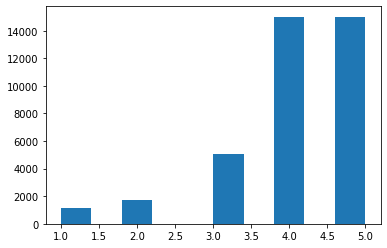

In [6]:
import re
opinions = []

for i in reviews:
  labels.append(i['overall'])
  text.append(i['reviewText'])
  if i['overall'] != 5.0:
    opinions.append(i)
    labels_reduced.append(i['overall'])
  elif count < 15000:
    count+=1
    opinions.append(i)
    labels_reduced.append(i['overall'])
print('Number of samples')
print(len(opinions))

plt.hist(labels_reduced,density=False)
plt.show()

Use the complete dataset with only letters and  analisis

Number of samples:
53258


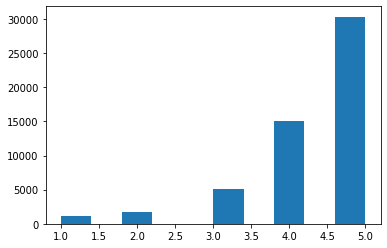

In [7]:
#OnlyLetters
for i in reviews:
  i['reviewText'] = re.sub(r'[^a-zA-Z ]+', '', i['reviewText'])
opinions = reviews
print('Number of samples:')
print(len(opinions))

plt.hist(labels, density=False)
plt.show()

Use the complete dataset and analysis

Number of samples:
53258


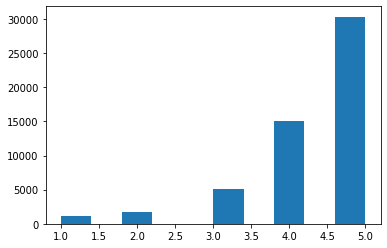

In [8]:
opinions = reviews
print('Number of samples:')
print(len(opinions))

plt.hist(labels, density=False)
plt.show()

Creating the dataset class

In [0]:

import torch
from torchtext import data
from torchtext.data import Dataset
SEED = 1234

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

TEXT = data.Field(tokenize = 'spacy')
LABEL = data.LabelField()

fields = [('text', TEXT), ('label', LABEL)]

examples = []

for i in opinions:
  examples.append(data.Example.fromlist([i['reviewText'],i['overall']],fields))

review_dataset = Dataset(examples,fields)


Split the data: 80% train, 10% validation, 10% test



In [10]:
import random

train_data, valid_data, test_data = review_dataset.split(split_ratio = [0.8,0.1,0.1],random_state = random.seed(SEED))

vars(train_data[-1])

{'label': 5.0,
 'text': ['As',
  'a',
  'teacher',
  'its',
  'nice',
  'to',
  'find',
  'a',
  'resource',
  'of',
  'cheap',
  'school',
  'supplies',
  'as',
  'I',
  'am',
  'constantly',
  'having',
  'to',
  'replace',
  'them',
  ' ']}

Build the vocab from the train_data

In [11]:
MAX_VOCAB_SIZE = 10_000

TEXT.build_vocab(train_data, 
                 max_size = MAX_VOCAB_SIZE, 
                 vectors = "glove.6B.100d", 
                 unk_init = torch.Tensor.normal_)

LABEL.build_vocab(train_data)

.vector_cache/glove.6B.zip: 862MB [06:29, 2.21MB/s]                          
100%|█████████▉| 398555/400000 [00:16<00:00, 23423.08it/s]

In [12]:
print(TEXT.vocab.stoi)

defaultdict(<function _default_unk_index at 0x7ffad2772e18>, {'<unk>': 0, '<pad>': 1, 'the': 2, ' ': 3, 'to': 4, 'a': 5, 'I': 6, 'and': 7, 'is': 8, 'of': 9, 'it': 10, 'for': 11, 'that': 12, 'you': 13, 'in': 14, 'this': 15, 'on': 16, 'with': 17, 'are': 18, 'have': 19, 'my': 20, 'nt': 21, 'The': 22, 'but': 23, 'not': 24, 'as': 25, 'be': 26, 'or': 27, 'was': 28, 'use': 29, 'can': 30, 'so': 31, 'do': 32, 'printer': 33, 'one': 34, 'they': 35, 'up': 36, 'like': 37, 'very': 38, 'It': 39, 'paper': 40, 'them': 41, 'at': 42, 'these': 43, 'from': 44, 'would': 45, 'out': 46, 'if': 47, 'will': 48, 'just': 49, 'more': 50, 'This': 51, 'its': 52, 'an': 53, 'all': 54, 'than': 55, 'your': 56, 'when': 57, 'has': 58, 'well': 59, 'good': 60, 'great': 61, 'had': 62, 'which': 63, 'does': 64, 'ink': 65, 'easy': 66, 'get': 67, 'about': 68, 'other': 69, 'also': 70, 'me': 71, 'tape': 72, 'only': 73, 'used': 74, 'no': 75, 'print': 76, 'time': 77, 'need': 78, 'really': 79, 'some': 80, 'much': 81, 'work': 82, 'usin

Set up the iterator

In [0]:
BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE,
    sort_within_batch = True,
    sort_key = lambda x: len(x.text), 
    device = device)

Convolutional NN definition

In [0]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, 
                 dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        self.convs = nn.ModuleList([
                                    nn.Conv2d(in_channels = 1, 
                                              out_channels = n_filters, 
                                              kernel_size = (fs, embedding_dim)) 
                                    for fs in filter_sizes
                                    ])
        
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        
        #text = [sent len, batch size]
        
        text = text.permute(1, 0)
                
        #text = [batch size, sent len]
        
        embedded = self.embedding(text)
                
        #embedded = [batch size, sent len, emb dim]
        
        embedded = embedded.unsqueeze(1)
        
        #embedded = [batch size, 1, sent len, emb dim]
        
        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]
            
        #conv_n = [batch size, n_filters, sent len - filter_sizes[n]]
        
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        
        #pooled_n = [batch size, n_filters]
        
        cat = self.dropout(torch.cat(pooled, dim = 1))

        #cat = [batch size, n_filters * len(filter_sizes)]
            
        return self.fc(cat)

In [15]:

INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
N_FILTERS = 100
FILTER_SIZES = [2,3,4]
OUTPUT_DIM = len(LABEL.vocab)
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = CNN(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)

print(model)


CNN(
  (embedding): Embedding(10002, 100)
  (convs): ModuleList(
    (0): Conv2d(1, 100, kernel_size=(2, 100), stride=(1, 1))
    (1): Conv2d(1, 100, kernel_size=(3, 100), stride=(1, 1))
    (2): Conv2d(1, 100, kernel_size=(4, 100), stride=(1, 1))
  )
  (fc): Linear(in_features=300, out_features=5, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [0]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 1,092,005 trainable parameters


In [0]:
pretrained_embeddings = TEXT.vocab.vectors

model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[-0.1117, -0.4966,  0.1631,  ...,  1.2647, -0.2753, -0.1325],
        [-0.8555, -0.7208,  1.3755,  ...,  0.0825, -1.1314,  0.3997],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [ 0.2885,  0.5558,  0.3386,  ...,  0.2486, -0.2973,  0.0748],
        [-0.5088,  0.2616, -0.4246,  ...,  0.4455,  1.1573,  0.1265],
        [ 0.4928, -0.3265, -0.0446,  ..., -0.1318,  0.1153, -0.0914]])

In [0]:
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

Set optimizer and loss function

In [0]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters())

criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

In [0]:
def categorical_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    max_preds = preds.argmax(dim = 1, keepdim = True) # get the index of the max probability
    correct = max_preds.squeeze(1).eq(y)
    return correct.sum() / torch.FloatTensor([y.shape[0]])

Define train  and evaluate function

In [0]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        
        predictions = model(batch.text)
        
        loss = criterion(predictions, batch.label)
        
        acc = categorical_accuracy(predictions, batch.label)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            predictions = model(batch.text)
            
            loss = criterion(predictions, batch.label)
            
            acc = categorical_accuracy(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Train the model and save it (Very slow, models are saved)

In [0]:
N_EPOCHS = 20

best_valid_loss = float('inf')
train_losses = []
valid_losses = []
for epoch in range(N_EPOCHS):

    start_time = time.time()
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), results_path+ '/model_onlyLetters.ckpt' )
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')



Epoch: 01 | Epoch Time: 5m 14s
	Train Loss: 1.077 | Train Acc: 56.36%
	 Val. Loss: 0.956 |  Val. Acc: 59.47%
Epoch: 02 | Epoch Time: 5m 7s
	Train Loss: 0.963 | Train Acc: 60.20%
	 Val. Loss: 0.897 |  Val. Acc: 62.33%
Epoch: 03 | Epoch Time: 5m 11s
	Train Loss: 0.897 | Train Acc: 62.74%
	 Val. Loss: 0.874 |  Val. Acc: 63.52%
Epoch: 04 | Epoch Time: 5m 5s
	Train Loss: 0.846 | Train Acc: 64.94%
	 Val. Loss: 0.871 |  Val. Acc: 63.66%
Epoch: 05 | Epoch Time: 5m 0s
	Train Loss: 0.799 | Train Acc: 66.75%
	 Val. Loss: 0.859 |  Val. Acc: 63.27%
Epoch: 06 | Epoch Time: 5m 0s
	Train Loss: 0.757 | Train Acc: 68.54%
	 Val. Loss: 0.857 |  Val. Acc: 63.80%
Epoch: 07 | Epoch Time: 5m 3s
	Train Loss: 0.710 | Train Acc: 70.77%
	 Val. Loss: 0.882 |  Val. Acc: 63.49%
Epoch: 08 | Epoch Time: 5m 4s
	Train Loss: 0.670 | Train Acc: 72.46%
	 Val. Loss: 0.904 |  Val. Acc: 64.18%
Epoch: 09 | Epoch Time: 5m 6s
	Train Loss: 0.633 | Train Acc: 74.45%
	 Val. Loss: 0.915 |  Val. Acc: 63.71%
Epoch: 10 | Epoch Time: 5m

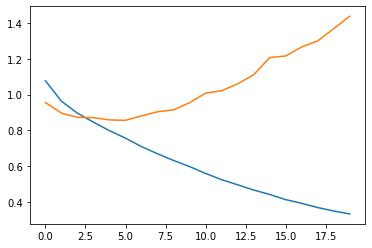

In [0]:
plt.plot(train_losses)
plt.plot(valid_losses)


Reduced data model  prediction

In [0]:
#Load the model
model.load_state_dict(torch.load(results_path+'model_reducedData.ckpt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 1.393 | Test Acc: 42.41%


Complete dataset model prediction

In [0]:
model.load_state_dict(torch.load(results_path+'model.ckpt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.851 | Test Acc: 65.32%


In [0]:
#Only letter dataset
model.load_state_dict(torch.load(results_path+'model_onlyLetters.ckpt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.876 | Test Acc: 63.65%
